# Исследование данных о продажах компьютерных игр 
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.   

Имеющиеся данные - файл 'games.csv', - информация об играх, выпущенных в продажу с 1980 по 2016г: название, жанр, платформа, год релиза, продажи в 3х регионах (Северная Америка, Европа, Япония), оценки пользователей и критиков, рейтинг по ESRB. 

**Цель исследования:** Определить закономерности, вляющие на успешность игры

**Ход работы:**  
Для выявления закономерностей, изучить общую иформацию о файле с данными games.csv  
Подготовить данные для анализа
Провести исследование:  
- определить актуальный период для прогноза на 2017 год
- определить потенциально прибыльные платформы
- выявить, зависят ли продажи от отзывов пользователей и критиков
- выявить наиболее прибыльные жанры
- составить портрет пользователя для регионов: Северная Америка, Европа, Япония (наиболее популярные платформы, жанры, возрастные категории игр)  
На основе исследования определить факторы успешности игры в 2017г.


## Ознакомление с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
# визуализация 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [4]:
#функция для предпросмотра данных
def description(dframe):
    display('Первые 5 строк:')
    display(dframe.head())
    display('Общая информация:')
    dframe.info()
    display('Пропуски:')
    display(pd.concat([dframe.isna().sum(), dframe.isna().mean()], axis=1)\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0:'кол-во', 1:'доля'})\
    .style.format({'кол-во':'{:.0f}', 'доля':'{:.2%}'}))
    display('Дубликаты:')
    display(dframe.duplicated().sum())
    
description(games)

'Первые 5 строк:'

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


'Общая информация:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


'Пропуски:'

,кол-во,доля
Critic_Score,8578,51.32%
Rating,6766,40.48%
User_Score,6701,40.09%
Year_of_Release,269,1.61%
Name,2,0.01%
Genre,2,0.01%
Platform,0,0.00%
NA_sales,0,0.00%
EU_sales,0,0.00%
JP_sales,0,0.00%


'Дубликаты:'

0

## Предобработка данных

Названия столбцов привожу к нижнему регистру:

In [5]:
games.columns = games.columns.str.lower()

Преобразуйю данные в нужные типы:

In [6]:
#Удаляю строки, где пропущен год выпуска и заменяю тип данных в столбце year_of_release на int
games = games.dropna(subset = ['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype('int')

In [7]:
#В столбце user_score пропуски оставляю, меняю тип на float
#tbd - to be determied - "требует уточнения", поэтому заменяем на nan, чтобы не удалять полезные 2376 строк
games.loc[games['user_score'] == 'tbd','user_score'] = float('nan')
games['user_score'] = games['user_score'].astype('float') 

В столбце **rating** более половины данных - пропуски. Это означает, что категория по ESRB не присвоена либо т.к. издатель не запросил, либо игра выпущена еще до появления ESRB в 1994м. Удалять их нецелесообразно, т.к. утратятся данные, поэтому заменим на "no_rating".

In [8]:
games['rating'] = games['rating'].fillna("no_rating")

In [9]:
#Строки без названия игры удаляю:
games = games.dropna(subset = ['name'])

In [10]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


**Дубликаты**

In [11]:
games.duplicated().sum()

0

Дубликатов нет.

Считаю суммарные продажи во всех регионах и заношу в отдельный столбец:

In [12]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis = 1)

## Исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

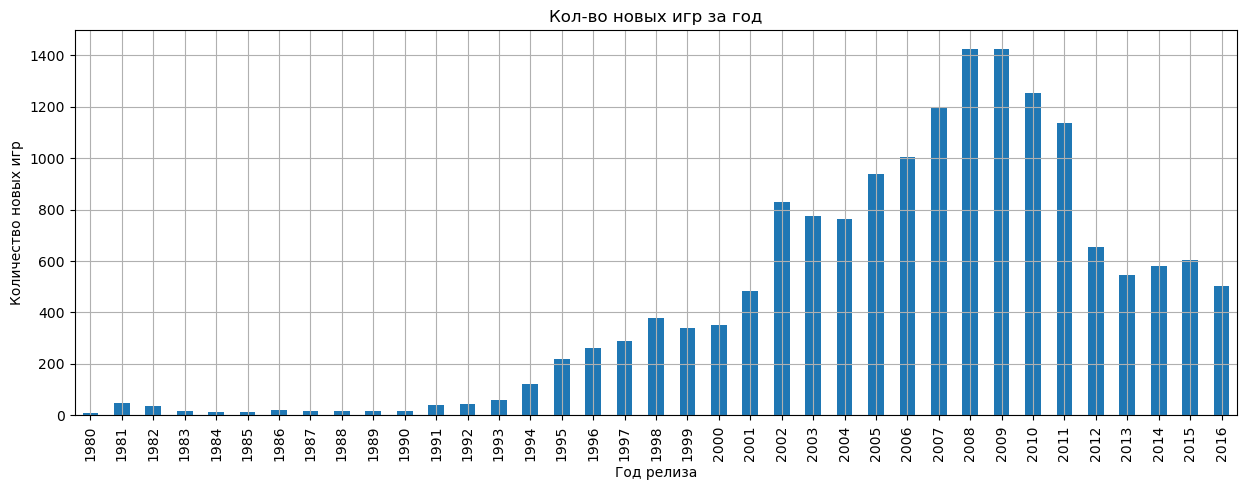

In [13]:
games.groupby('year_of_release')['name'].count() \
    .plot(kind='bar', figsize=(15, 5), title='Кол-во новых игр за год', grid=True) \
    .set(xlabel='Год релиза', ylabel='Количество новых игр')
plt.show()

Для выявления закономерностей и актуального прогнозирования данные за все годы мне не потребуются, т.к. фактически на графике представлено развитие игровой индустрии и данные за 20й век не показательны с учетом технического прогресса)

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

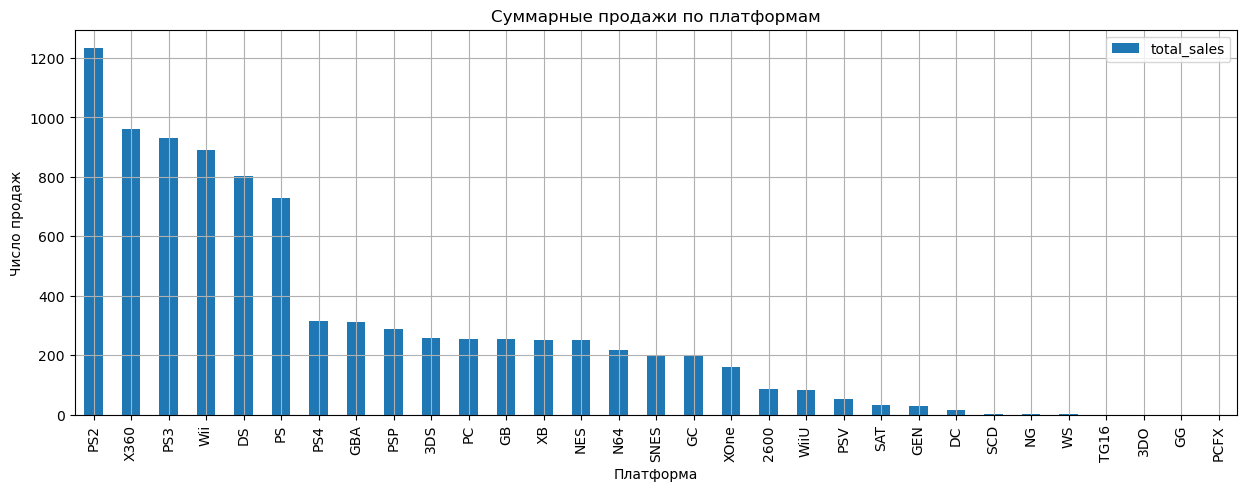

In [14]:
#Считаю суммарные продажи для всех платформ
games.groupby('platform').agg({'total_sales':'sum'}) \
    .sort_values(by = 'total_sales', ascending = False) \
    .plot(kind='bar', figsize=(15, 5), title='Суммарные продажи по платформам', grid=True) \
    .set(xlabel='Платформа', ylabel='Число продаж') 
plt.show()

По общим продажам лидируют первые 6 платформ: PS2, X360, Wii, PS3, DS, PS. Для каждой из них строю распределение продаж по годам:

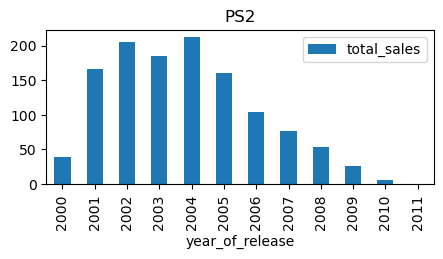

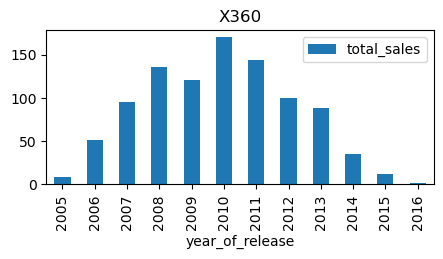

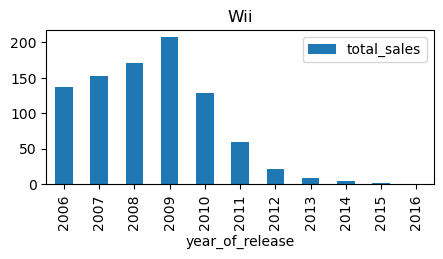

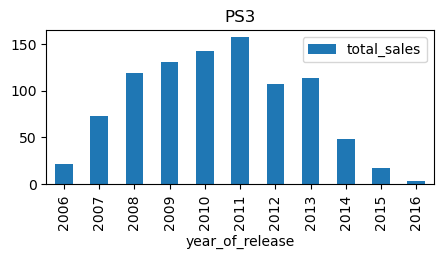

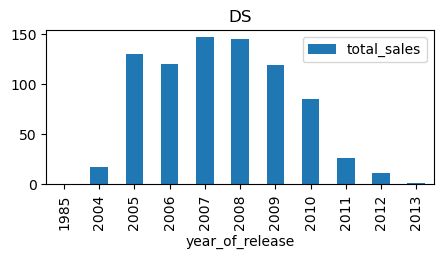

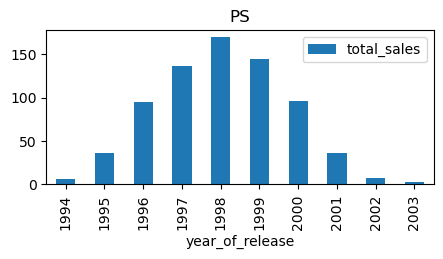

In [15]:
top_platforms = ['PS2', 'X360', 'Wii', 'PS3', 'DS', 'PS']

for platform in top_platforms:
    games[games['platform'] == platform] \
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum') \
        .plot(kind='bar', figsize=(5,2))
    plt.title(platform)

In [16]:
#Nintendo DS вышла в 2004м году, а что за продажи в 1985м
games.query('platform == "DS" & year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,no_rating,0.02


Похоже, адаптировали игру под DS уже после выхода платформы, а год указан первой версии игры. На анализ это не повляет, т.к. 1985й год не входит в актуальный период.

**Вывод:** Судя по графикам, "жизненный" цикл игровой платформы от 7ми до 9ти лет. И первую половину этого периода продажи возрастают, а вторую - снижаются. На примере Sony PlayStation - PS, PS2 и PS3 видно, что с появлением следующей версии платформы, продажи предыдущей заметно падают. 

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Хотя периодом для выявленния закономерностей очевидно является 1994 - 2016, т.к. в 1994м выпустилась PS и вслед за ней популярные консоли, но актуальный прогноз можно сделать на основании данных за половину так называемого периода популярности платформы, выявленного в предыдущем пункте (в среднем 7-9 лет) - 5лет. Таким образом выбираю данные за эти годы 2012-2016:

In [17]:
actual_games = games.query('year_of_release >= 2012')

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

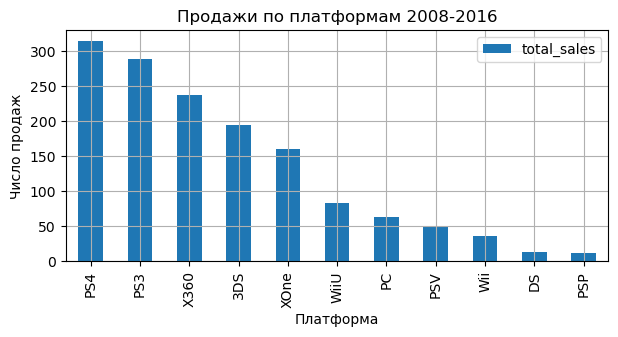

In [18]:
actual_games.groupby('platform').agg({'total_sales':'sum'}) \
    .sort_values(by = 'total_sales', ascending = False) \
    .plot(kind='bar', figsize=(7, 3), title='Продажи по платформам 2008-2016', grid=True) \
    .set(xlabel='Платформа', ylabel='Число продаж') 
plt.show()

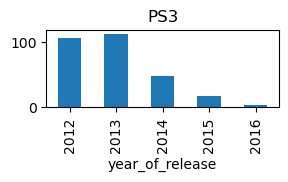

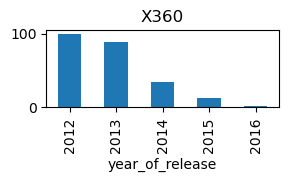

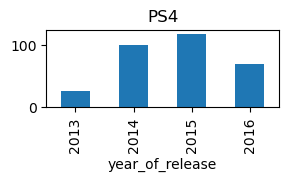

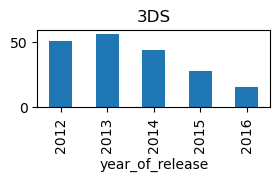

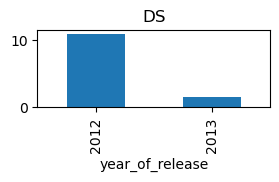

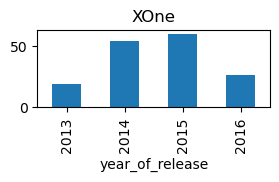

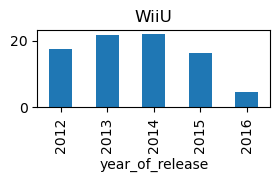

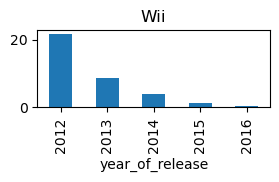

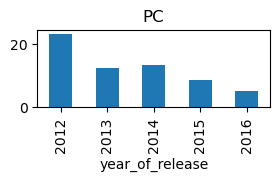

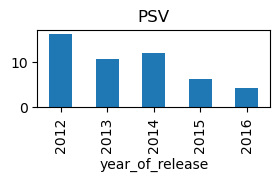

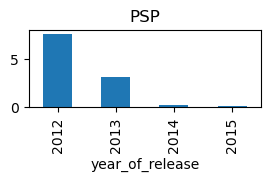

In [19]:
actual_platforms = actual_games['platform'].unique()

for platform in actual_platforms:
    actual_games[actual_games['platform'] == platform] \
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum') \
        .plot(kind='bar', figsize=(3,1), legend=False)
    plt.title(platform)

Лидируют по продажам с 2012 по 2016 платформы  PS4 и PS3, X360, 3DS. При этом продажи PS4 растут, а X360, 3DS и PS3 - падают. Потенциально прибыльными считаю платформы PS4, XOne. А также 3DS, несмотря на падение продаж, ещё принесет прибыль, учитывая тенденцию к плавному снижению продаж среди популярных приставок прошлых поколений. 

In [20]:
#PSP и DS из дальнейшего исследования исключаем, т.к. продажи завершены еще до 2016года.
actual_games = actual_games.query('platform != "PSP" & platform != "DS"')

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

(0.0, 4.0)

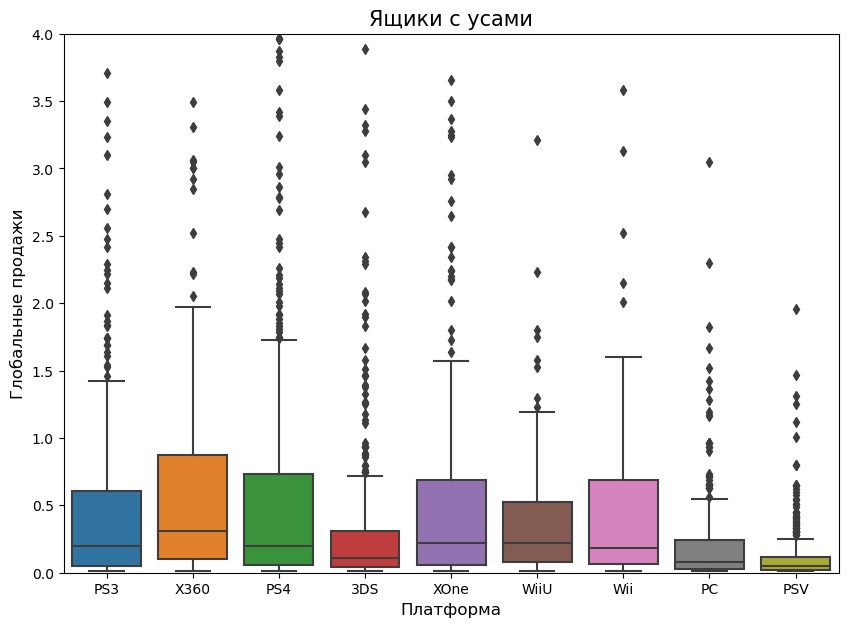

In [21]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=actual_games, x='platform', y='total_sales')
plt.title('Ящики с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)
plt.ylim([0, 4])

Данные диапазоны указывают на то, в каком размахе располагается основная масса значений характеризующих суммарный объём продаж для каждой игры. Медиана у всех приставок разная, что связано с разным годом выпуска приставки и разным этапом популярности в рассматриваеный период. Наибольшая часть данных общих продаж в среднем не привышает 1,5 миллиона копий, за исключением платформы X360. У X360 и XOne среднее число общих продаж выше, чем у остальных, а зачит большее количество игр продается бОльшим тиражом.  

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для рассмотрения возьму платформу PS4:

In [22]:
ps4_games = actual_games[actual_games['platform']=='PS4']

Корреляция отзывы пользователей/продажи: -0.03195711020455646


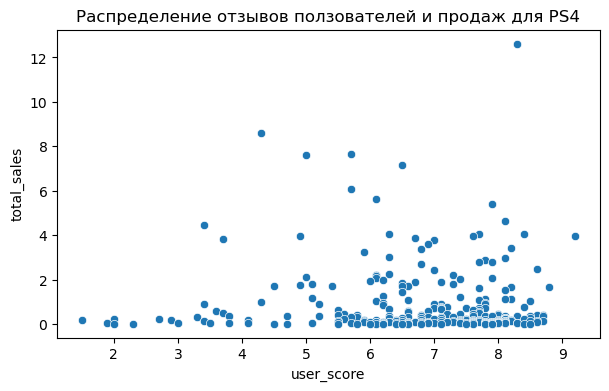

In [23]:
print('Корреляция отзывы пользователей/продажи:', ps4_games['user_score'].corr(ps4_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='user_score', y='total_sales', data=ps4_games)
plt.title('Распределение отзывов ползователей и продаж для PS4')
plt.show()

Корреляция между отзывами пользователей и продажами игр на платформе PS4 практически отсутствует - 0.03. Значит отзывы пользователей не влияют на продажи игр для данной платформы.

Корреляция отзывы критиков/продажи: 0.4065679020617814


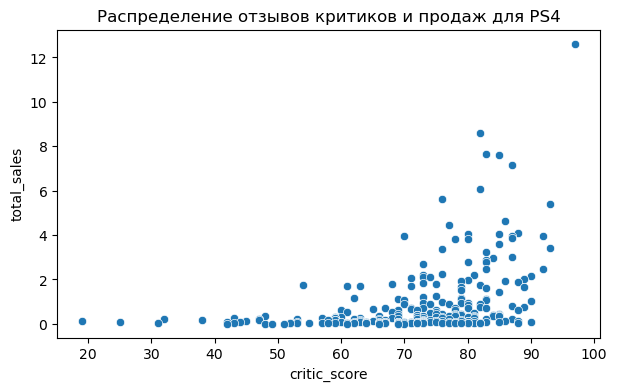

In [24]:
print('Корреляция отзывы критиков/продажи:', ps4_games['critic_score'].corr(ps4_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4_games)
plt.title('Распределение отзывов критиков и продаж для PS4')
plt.show()

Есть небольшая корреляция между отзывами критиков и продажами игр на PS4. Это означает, что отзывы критиков слабо влияют на продажи игр на PS4.  

**Вывод** Таким образом, взаимосвязи между оценками пользователей и продажами нет. Есть небольшая взаимосвязь между оценками критиков и продажами. Графики показывают, что игры с большими продажами имели высокие оценки критиков, но не все игры с высокой оценкой критиков имели высокие продажи. Предполагаю, что цифры продаж в большей степени зависят от рекламы продукта. 

### Соотнесите выводы с продажами игр на других платформах.

In [25]:
actual_platforms = actual_games['platform'].unique()
print('Коэффициенты корреляции:')
print()
for platform_name in actual_platforms:
    print(platform_name, ':', 'Оценки пользователей и продажи:', \
          round(actual_games[actual_games['platform']==platform_name]['user_score'] \
          .corr(actual_games[actual_games['platform']==platform_name]['total_sales']), 2))
    print(platform_name, ':', 'Оценки критиков и продажи:', \
          round(actual_games[actual_games['platform']==platform_name]['critic_score'] \
          .corr(actual_games[actual_games['platform']==platform_name]['total_sales']), 2))
    print('')
   

Коэффициенты корреляции:

PS3 : Оценки пользователей и продажи: -0.01
PS3 : Оценки критиков и продажи: 0.33

X360 : Оценки пользователей и продажи: 0.01
X360 : Оценки критиков и продажи: 0.36

PS4 : Оценки пользователей и продажи: -0.03
PS4 : Оценки критиков и продажи: 0.41

3DS : Оценки пользователей и продажи: 0.2
3DS : Оценки критиков и продажи: 0.32

XOne : Оценки пользователей и продажи: -0.07
XOne : Оценки критиков и продажи: 0.42

WiiU : Оценки пользователей и продажи: 0.4
WiiU : Оценки критиков и продажи: 0.35

Wii : Оценки пользователей и продажи: 0.3
Wii : Оценки критиков и продажи: -0.42

PC : Оценки пользователей и продажи: -0.12
PC : Оценки критиков и продажи: 0.24

PSV : Оценки пользователей и продажи: -0.0
PSV : Оценки критиков и продажи: 0.09



#### Рассмотрим влияние отзвов пользователей и критиков на продажи для других платформ: 

#### PS3

In [26]:
ps3_games = actual_games[actual_games['platform']=='PS3']

Корреляция отзывы пользователей/продажи: -0.005143522887113785


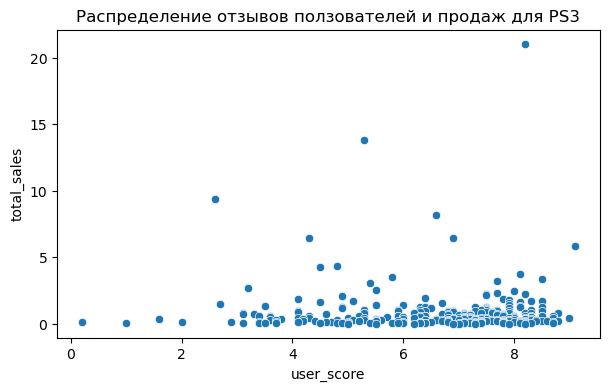

In [27]:
print('Корреляция отзывы пользователей/продажи:', ps3_games['user_score'].corr(ps3_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='user_score', y='total_sales', data=ps3_games)
plt.title('Распределение отзывов ползователей и продаж для PS3')
plt.show()

Корреляция отзывы критиков/продажи: 0.33149725926295903


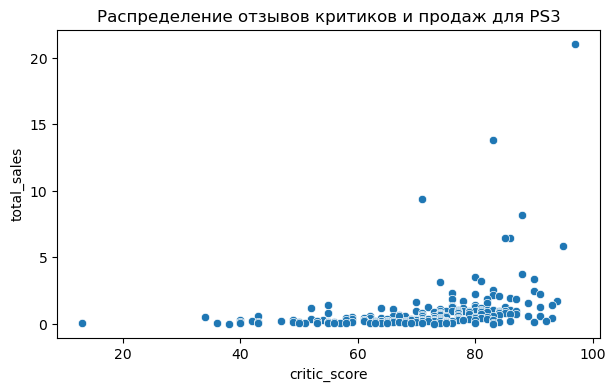

In [28]:
print('Корреляция отзывы критиков/продажи:', ps3_games['critic_score'].corr(ps3_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='critic_score', y='total_sales', data=ps3_games)
plt.title('Распределение отзывов критиков и продаж для PS3')
plt.show()

Для **PS3** корреляции такие же, как и дляя PS4 - пользовательские отзывы не влияют на продажи, а отзывы критиков слабо влияют.

#### XOne

In [29]:
xone_games = actual_games[actual_games['platform']=='XOne']

Корреляция отзывы пользователей/продажи: -0.06892505328279418


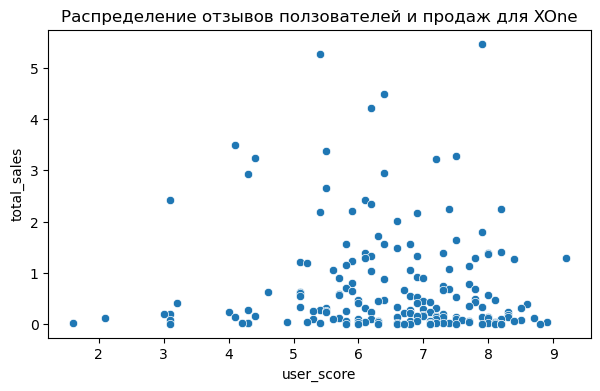

In [30]:
print('Корреляция отзывы пользователей/продажи:', xone_games['user_score'].corr(xone_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='user_score', y='total_sales', data=xone_games)
plt.title('Распределение отзывов ползователей и продаж для XOne')
plt.show()

Корреляция отзывы критиков/продажи: 0.4169983280084015


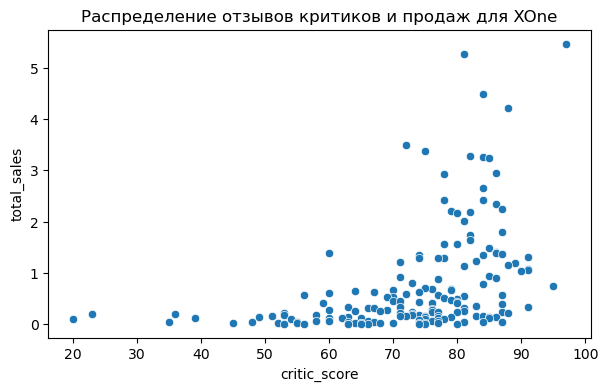

In [31]:
print('Корреляция отзывы критиков/продажи:', xone_games['critic_score'].corr(xone_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='critic_score', y='total_sales', data=xone_games)
plt.title('Распределение отзывов критиков и продаж для XOne')
plt.show()

Для **XOne** корреляции такие же, как и для PS4 и PS3 - пользовательские отзывы не влияют на продажи, а отзывы критиков слабо влияют.

#### 3DS

In [32]:
n3ds_games = actual_games[actual_games['platform']=='3DS']

Корреляция отзывы пользователей/продажи: 0.19758263411038593


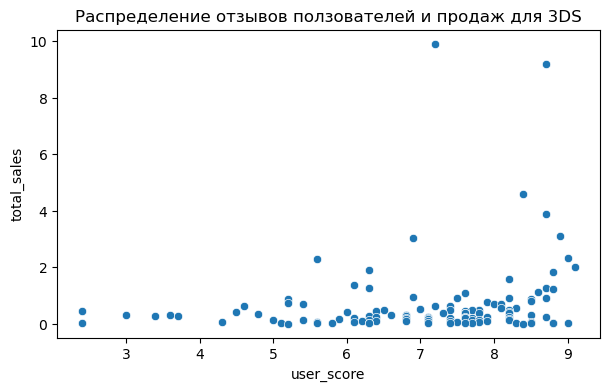

In [33]:
print('Корреляция отзывы пользователей/продажи:', n3ds_games['user_score'].corr(n3ds_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='user_score', y='total_sales', data=n3ds_games)
plt.title('Распределение отзывов ползователей и продаж для 3DS')
plt.show()

Корреляция отзывы критиков/продажи: 0.32080286953607856


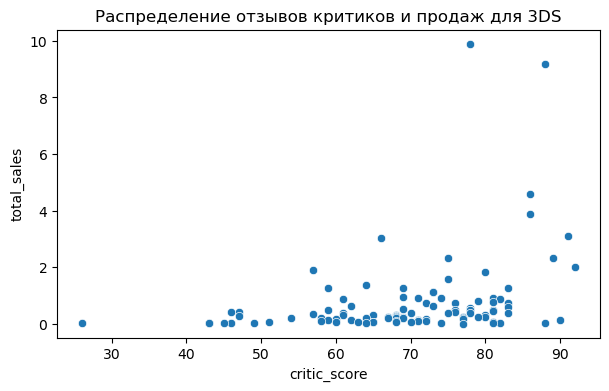

In [34]:
print('Корреляция отзывы критиков/продажи:', n3ds_games['critic_score'].corr(n3ds_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='critic_score', y='total_sales', data=n3ds_games)
plt.title('Распределение отзывов критиков и продаж для 3DS')
plt.show()

Оценки пользователей и критиков практически не влияют на продажи игр на **3DS**. Что сопоставимо с предыдущими рассмотренными платформами.

#### X360

In [35]:
x360_games = actual_games[actual_games['platform']=='X360']

Корреляция отзывы пользователей/продажи: 0.006163978646213357


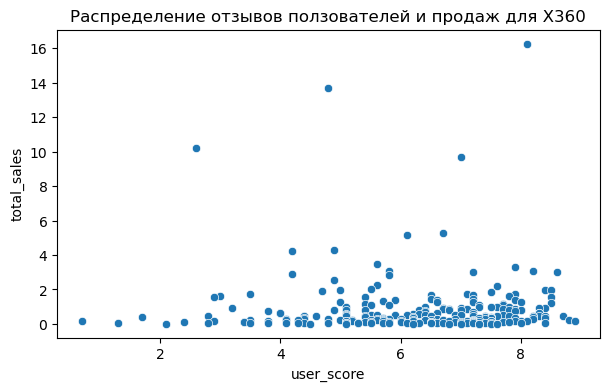

In [36]:
print('Корреляция отзывы пользователей/продажи:', x360_games['user_score'].corr(x360_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='user_score', y='total_sales', data=x360_games)
plt.title('Распределение отзывов ползователей и продаж для X360')
plt.show()

Корреляция отзывы критиков/продажи: 0.3605734888507339


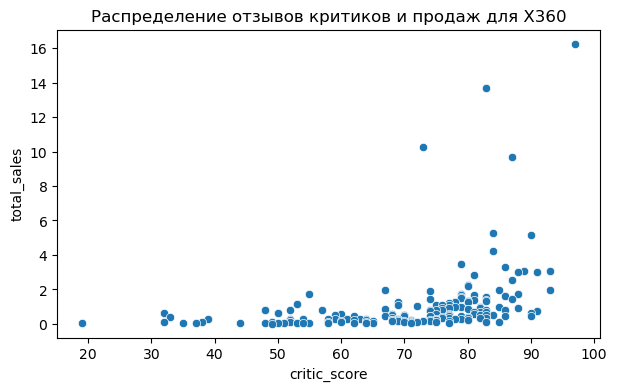

In [37]:
print('Корреляция отзывы критиков/продажи:', x360_games['critic_score'].corr(x360_games['total_sales']))
plt.figure(figsize=(7,4))
sns.scatterplot(x='critic_score', y='total_sales', data=x360_games)
plt.title('Распределение отзывов критиков и продаж для X360')
plt.show()

Как и в предыдущих рассмотренных платформах, для **X360** корреляция между отзывами пользователей и продажами отсутствует, а корреляция между отзывами критиков и продажами слабая.

Выводы для PS4 сопоставимы с другими платформами. Корреляция между оценками пользователей и продажами очень низкая или отсутствует, а между оценками критиков и продажами есть небольшая корреляция, то есть в небольшой степени они влияют на продажи игр.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [38]:
genre_games = actual_games.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'mean'])
genre_games.columns = ['Продано млн копий', 'Число игр', 'Среднее продаж']
genre_games.sort_values(by='Среднее продаж', ascending=False)

,Продано млн копий,Число игр,Среднее продаж
genre,,,
Shooter,304.73,235,1.30
Platform,60.31,83,0.73
Sports,179.55,256,0.70
Role-Playing,180.91,339,0.53
Misc,84.15,180,0.47
Racing,53.50,115,0.47
Action,435.54,953,0.46
Simulation,34.85,78,0.45
Fighting,44.13,105,0.42


Action самый многочисленный жанр. Далее идут Shooter, Role-Playing и Sports. Наименее популярные жанры среди издателей - Puzzle, Strategy и Simulation.

По среднему числу продаж лидером является Shooter, далее идут Platform, Sports, при этом многочисленный Action лишь в середине списка, а наименее прибыльный жанр - Adventure. В жанре Shooter средняя цена игры высока, но их не очень много, а для жанра Action ситуация другая - игр очень много, средняя цена по ним невелика. 

## Портрет пользователя каждого региона

### Определите для пользователя каждого региона (NA, EU, JP):  
#### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

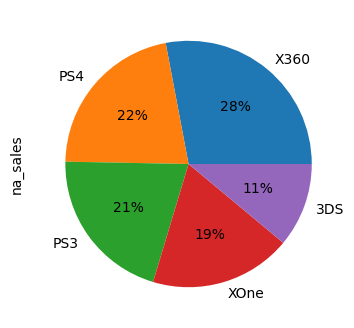

In [39]:
def user_platform(region):
    return actual_games.pivot_table(index='platform', values=region, aggfunc='sum').nlargest(5, region) \
        .plot(kind='pie', autopct='%1.0f%%', legend=False, figsize=(4, 4), subplots=True)

user_platform('na_sales')
plt.show()

В Северной Америке лидирует платформа X360, затем PS4 и PS3, XOne, 3DS.

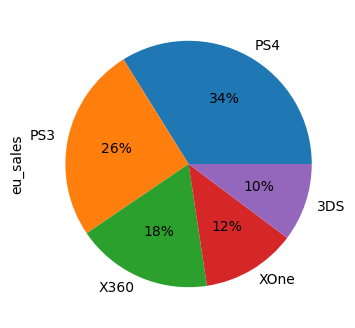

In [40]:
user_platform('eu_sales')
plt.show()

В то же время в Европе наиболее популярна платформа PS4, X360 на 3м месте после PS3.

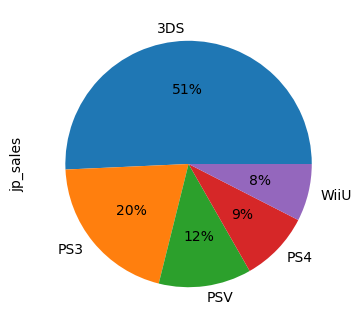

In [41]:
user_platform('jp_sales')
plt.show()

Япония и в этом рейтинге отличается - наиболее популярна консоль Nintendo 3DS, PS3 опережает PS4, а точнее сказать, PS4 еще не набрала популярности.

<div class="alert alert-success">
<b>Комментарий ревьюера v.2</b> 
    
👍 
Верная интерпретация полученных данных.
</div>

#### Самые популярные жанры (топ-5). Поясните разницу.

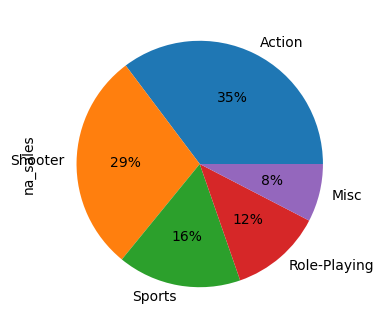

In [42]:
def user_genre(region):
    return actual_games.pivot_table(index='genre', values=region, aggfunc='sum').nlargest(5, region) \
        .plot(kind='pie', autopct='%1.0f%%', legend=False, figsize=(4, 4), subplots=True)

user_genre('na_sales')
plt.show()

В Северной Америке наиболее популярны жанры Action и Shooter, далее Sports и Role-Playing.

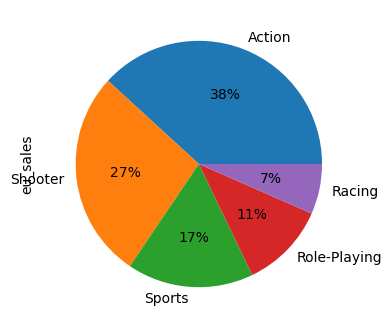

In [43]:
user_genre('eu_sales')
plt.show()

В Европе распределение жанров по популярности такое же, как в Севернй Америке.

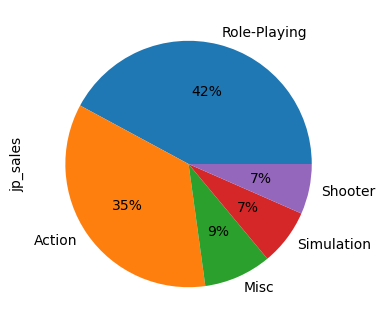

In [44]:
user_genre('jp_sales')
plt.show()

Для Японии рейтинг заметно отличается: Role-Playing с большим отрывом лидирует, Shooter на 5м месте, а Sports вообще не вошел в пятерку.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

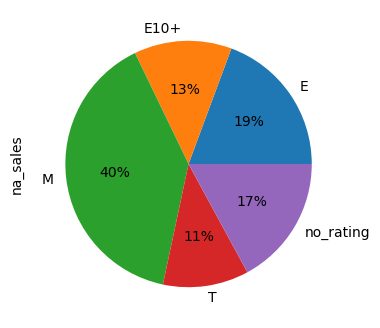

In [45]:
def user_rating(region):
    return actual_games.pivot_table(index='rating', values=region, aggfunc='sum') \
        .plot(kind='pie', autopct='%1.0f%%', legend=False, figsize=(4, 4), subplots=True)

user_rating('na_sales')
plt.show()

В Северной Америке лидирует категория игр М -для лиц старше 17лет. на втором месте Е - для лиц всех возрастных категорий. Игры без рейтинга занимают третье место.

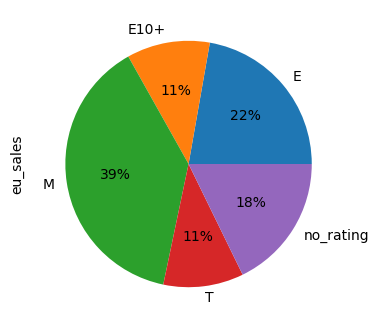

In [46]:
user_rating('eu_sales')
plt.show()

Для Европы характерно такое же распределение популярности игр по категориям ESRB, как для Северной Америки.

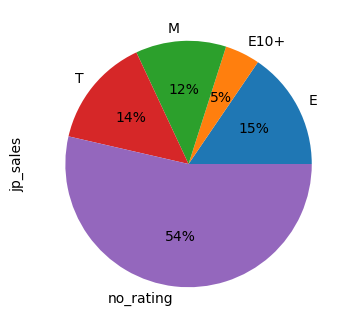

In [47]:
user_rating('jp_sales')
plt.show()

В Японии более половины проданых игр без присвоенного рейтинга ESRB. Категория Е(для всех возрастов) делит второе место с Т(старше 13 лет).

**Вывод:** Портрет пользователя для Северной Америки и Европы схож - игры с "взрослыми" цензурными ограничениями, новые версии консолей, жанры - Action, Shooter, Sports. Пользователи из Японии предпочитают жанры - Role-Playing, Action, на приставках 3DS и PS3, и болльше половины игр без оценки ESRB, т.к. вероятно большая доля этих игр была издана в Японии и оценена согласно японской рейтинговой модели CERO.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Нулевая гипотеза H₀ - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
Альтернативная гипотеза H₁ - средние пользовательские рейтинги платформ Xbox One и PC различаются.  
  
Совокупности оценок пользователей для данных платформ - независимые, поэтому воспользуемся методом ttest_ind. Параметр equal_var оставим по умолчанию - True, т.к. выборки равные по размеру. Порог вероятности в 5% для H₀ считаю достаточным для того, чтобы не отвергать гипотезу.  

In [48]:
xone = actual_games.query('platform == "XOne"')['user_score']
pc = actual_games.query('platform == "PC"')['user_score']

alpha = 0.05 

results = st.ttest_ind(xone, pc) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: nan
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Полученное значение p-value говорит о том, что нулевая гипотеза не может быть отвергнута, поэтому вероятно, что средние пользовательские рейтинги платформ Xbox One и PC одинаковы.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза H₀ - cредние пользовательские рейтинги жанров Action и Sports одинаковы.  
Альтернативная гипотеза H₁ - cредние пользовательские рейтинги жанров Action и Sports различаются.  
  
  Совокупности оценок пользователей для данных жанров - независимые, поэтому воспользуемся методом ttest_ind. Параметр equal_var оставим по умолчанию - True, т.к. выборки равные по размеру. Порог вероятности в 5% для H₀ считаю достаточным для того, чтобы не отвергать гипотезу.  

In [49]:
action = actual_games.query('genre == "Action"')['user_score']
sports = actual_games.query('genre == "Sports"')['user_score']

alpha = 0.05

results = st.ttest_ind(action, sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: nan
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Полученное значение p-value говорит о том, что нулевая гипотеза не может быть отвергнута, поэтому вероятно, что средние пользовательские рейтинги жанров Action и Sports одинаковы.

## Общий вывод

Успешность игры в 2017м году определяется следующими закономерностями:  
Планируя кампании на 2017-й год предпочтительно ориентироваться на набирающие популярность игровые платформы PS4 и XOne.  
Хорошо продаются игры в жанрах: Shooter, Action, Sports, Role-Playing.  
При этом лучше всего продавать игры с максимальной реалистичностью, рейтинга M, а на Японском рынке лучшим решением будет игра в жанре Role-Playing или Action, ориентированная на подростков старше 13 лет или для всех возрастов.